In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.config.set_soft_device_placement(True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import roc_curve,roc_auc_score
import numpy as np
import pandas as pd
import shutil
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(256, 256, 3)


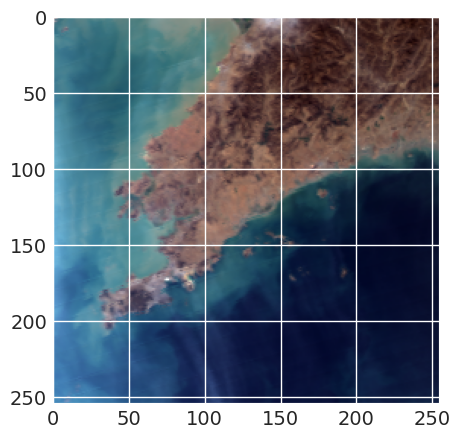

In [ ]:
import matplotlib.pyplot as plt
fpath=r'/content/drive/MyDrive/proj_dataset/data/Seaside/seaside_1.tif'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

In [ ]:
# Data Splitting
sdir=r'/content/drive/MyDrive/proj_dataset/data/'
classlist=os.listdir(sdir)
filepaths=[]
labels=[]
#classlist.remove(".DS_Store")
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
trsplit= .9
vsplit=.05
dsplit=vsplit/(1-trsplit)
train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
balance=list(train_df['labels'].value_counts())
for b in balance:
    print (b)

train_df length:  5602   test_df length:  312   valid_df length:  311
1049
923
911
911
906
902


In [ ]:
# Equal Number of Images in all categories (Balancing Data)
sample_list=[]
max_size= 902
min_size = 0
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size :
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count>= min_size:
        sample_list.append(group)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))
print (train_df['labels'].value_counts())
print(train_df)

5412
Haze       902
Seaside    902
Cloud      902
Dust       902
Smoke      902
Land       902
Name: labels, dtype: int64
                                              filepaths labels
0     /content/drive/MyDrive/proj_dataset/data/Haze/...   Haze
1     /content/drive/MyDrive/proj_dataset/data/Haze/...   Haze
2     /content/drive/MyDrive/proj_dataset/data/Haze/...   Haze
3     /content/drive/MyDrive/proj_dataset/data/Haze/...   Haze
4     /content/drive/MyDrive/proj_dataset/data/Haze/...   Haze
...                                                 ...    ...
5407  /content/drive/MyDrive/proj_dataset/data/Land/...   Land
5408  /content/drive/MyDrive/proj_dataset/data/Land/...   Land
5409  /content/drive/MyDrive/proj_dataset/data/Land/...   Land
5410  /content/drive/MyDrive/proj_dataset/data/Land/...   Land
5411  /content/drive/MyDrive/proj_dataset/data/Land/...   Land

[5412 rows x 2 columns]


In [ ]:
# Resize, Data Normalization, Data Augmentation
height=224
width=224
channels=3
batch_size=3
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=np.ceil((len(train_gen.labels)/batch_size))

test batch size:  78   test steps:  4
Found 5412 validated image filenames belonging to 6 classes.
Found 312 validated image filenames belonging to 6 classes.
Found 311 validated image filenames belonging to 6 classes.


In [ ]:
# Visualize the Data
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

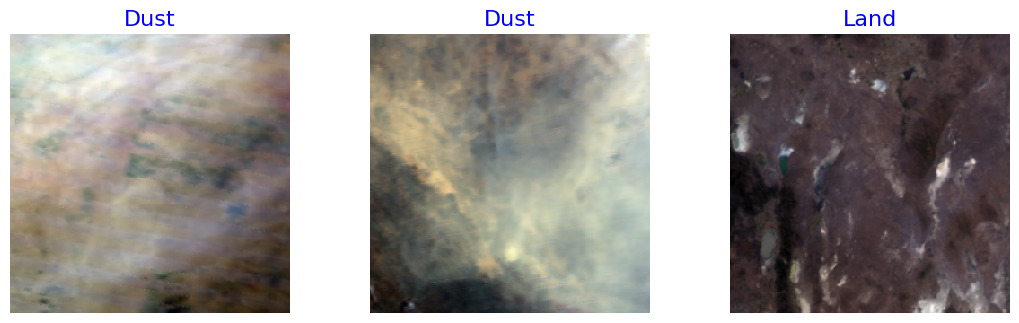

In [ ]:
show_image_samples(train_gen)

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
# Initialization of Parameters
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0
        self.best_epoch=1   # epoch with the lowest loss
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored

    def on_train_begin(self, logs=None):
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'
        print_in_color (msg, (244, 252, 3), (55,65,80))
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
        self.start_time= time.time()

    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count

    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        msg='setting base_model as trainable for fine tuning of model'
                        self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))
                        self.count=0
                        self.stop_count=0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial

                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

In [ ]:
# Model Performance
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
# Print Results
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
# Efficientnet Model
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs =25
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
with tf.device("/gpu:0"):
    callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]
    history=model.fit(x=train_gen, epochs=epochs, verbose=1,callbacks=callbacks, validation_data=valid_gen,validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

Epoch 1/25
1804/1804 [==============================] - ETA: 0s - loss: 4.6131 - accuracy: 0.4913 1 /25     4.613   49.132   2.62967  38.585   0.00100  0.00100  accuracy   174.27 

1804/1804 [==============================] - 174s 73ms/step - loss: 4.6131 - accuracy: 0.4913 - val_loss: 2.6297 - val_accuracy: 0.3859
Epoch 2/25
1804/1804 [==============================] - ETA: 0s - loss: 1.7512 - accuracy: 0.5767 2 /25     1.751   57.668   1.40125  69.132   0.00100  0.00100  accuracy   129.74 

enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again

10
 training will continue until epoch 12

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

1804/1804 [==============================] - 304s 169ms/step - loss: 1.7512 - accuracy: 0.5767 - val_loss: 1.4013 - val_accuracy: 0

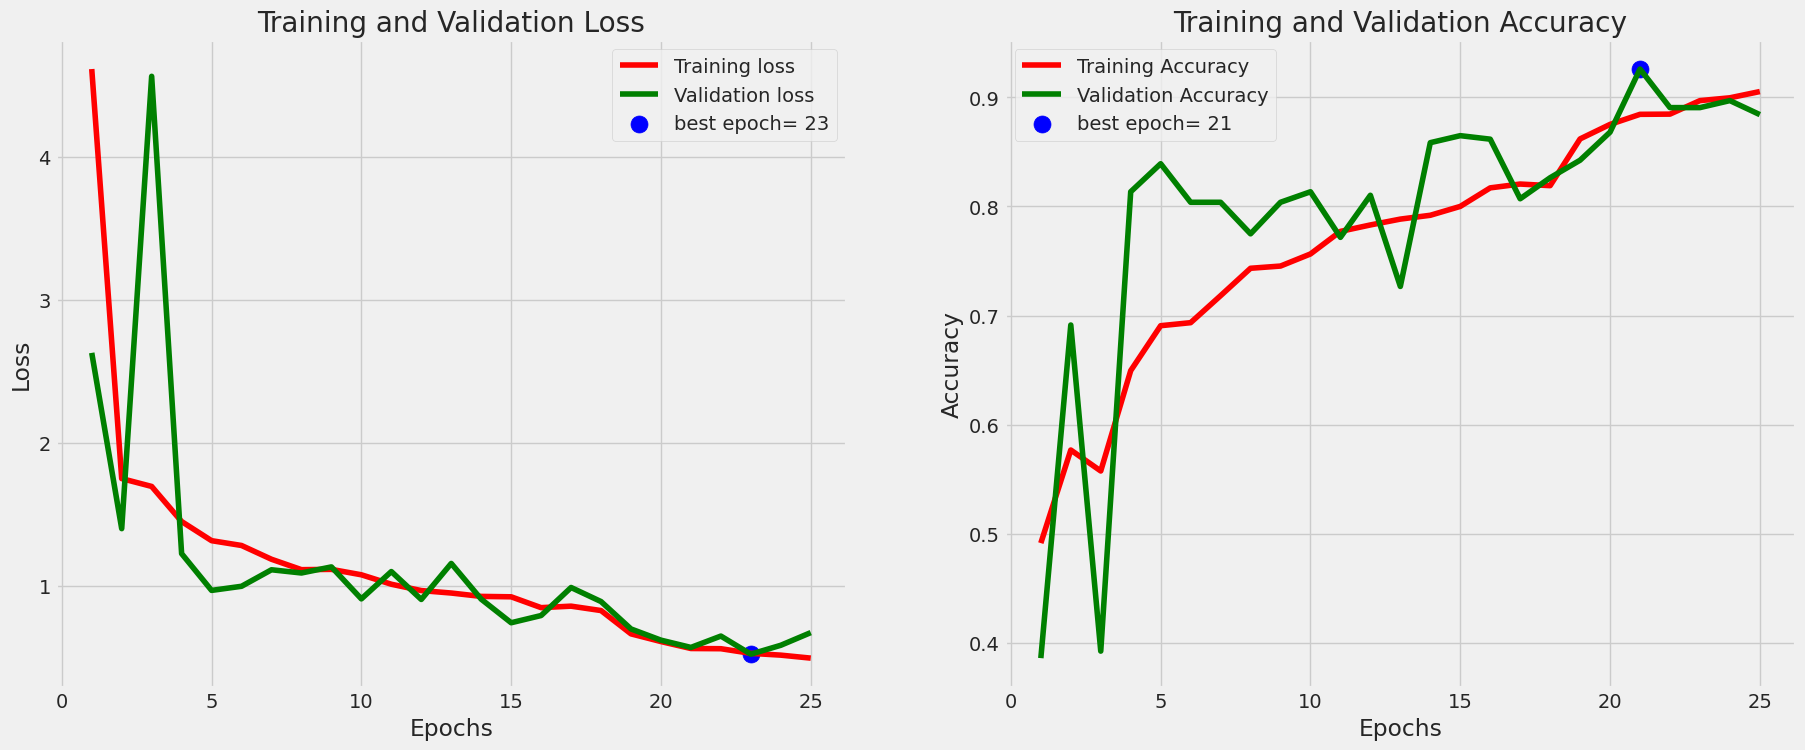

4/4 [==============================] - 1s 212ms/step - loss: 0.3944 - accuracy: 0.9519
accuracy on the test set is 95.19 %

model was saved as EfficientNetB1-scenes-95.19.h5



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='scenes'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
print_in_color ('model was saved as ' + save_id, (0,255,0),(55,65,80))
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

4/4 [==============================] - 3s 221ms/step


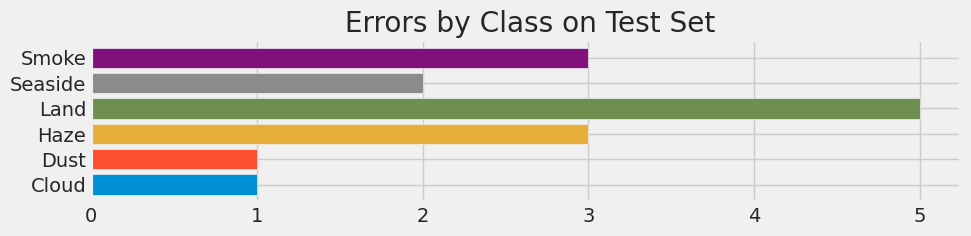

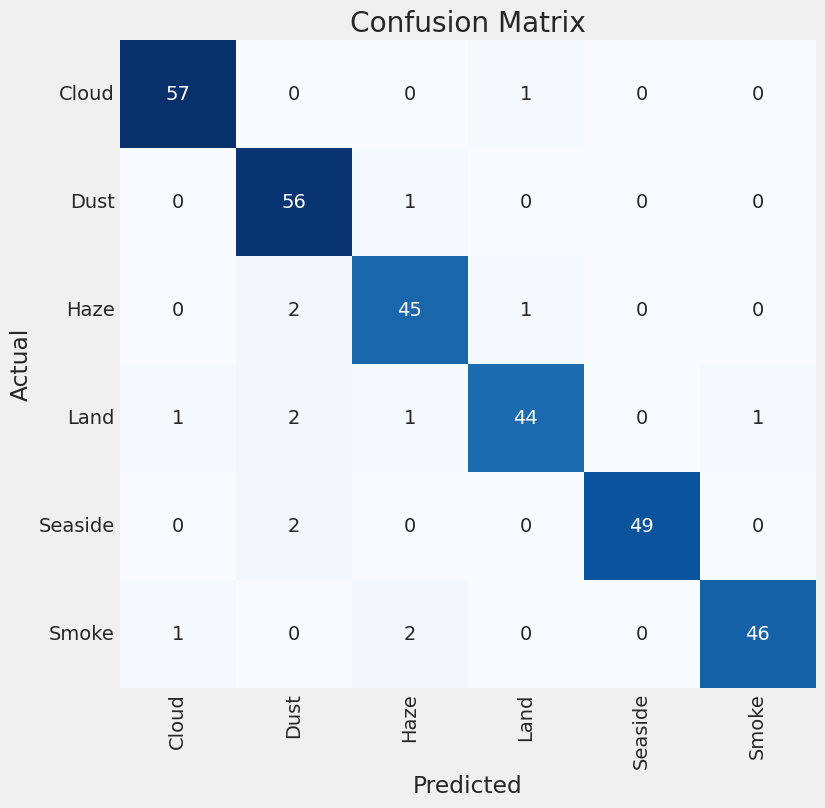

Classification Report:
----------------------
               precision    recall  f1-score   support

       Cloud       0.97      0.98      0.97        58
        Dust       0.90      0.98      0.94        57
        Haze       0.92      0.94      0.93        48
        Land       0.96      0.90      0.93        49
     Seaside       1.00      0.96      0.98        51
       Smoke       0.98      0.94      0.96        49

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

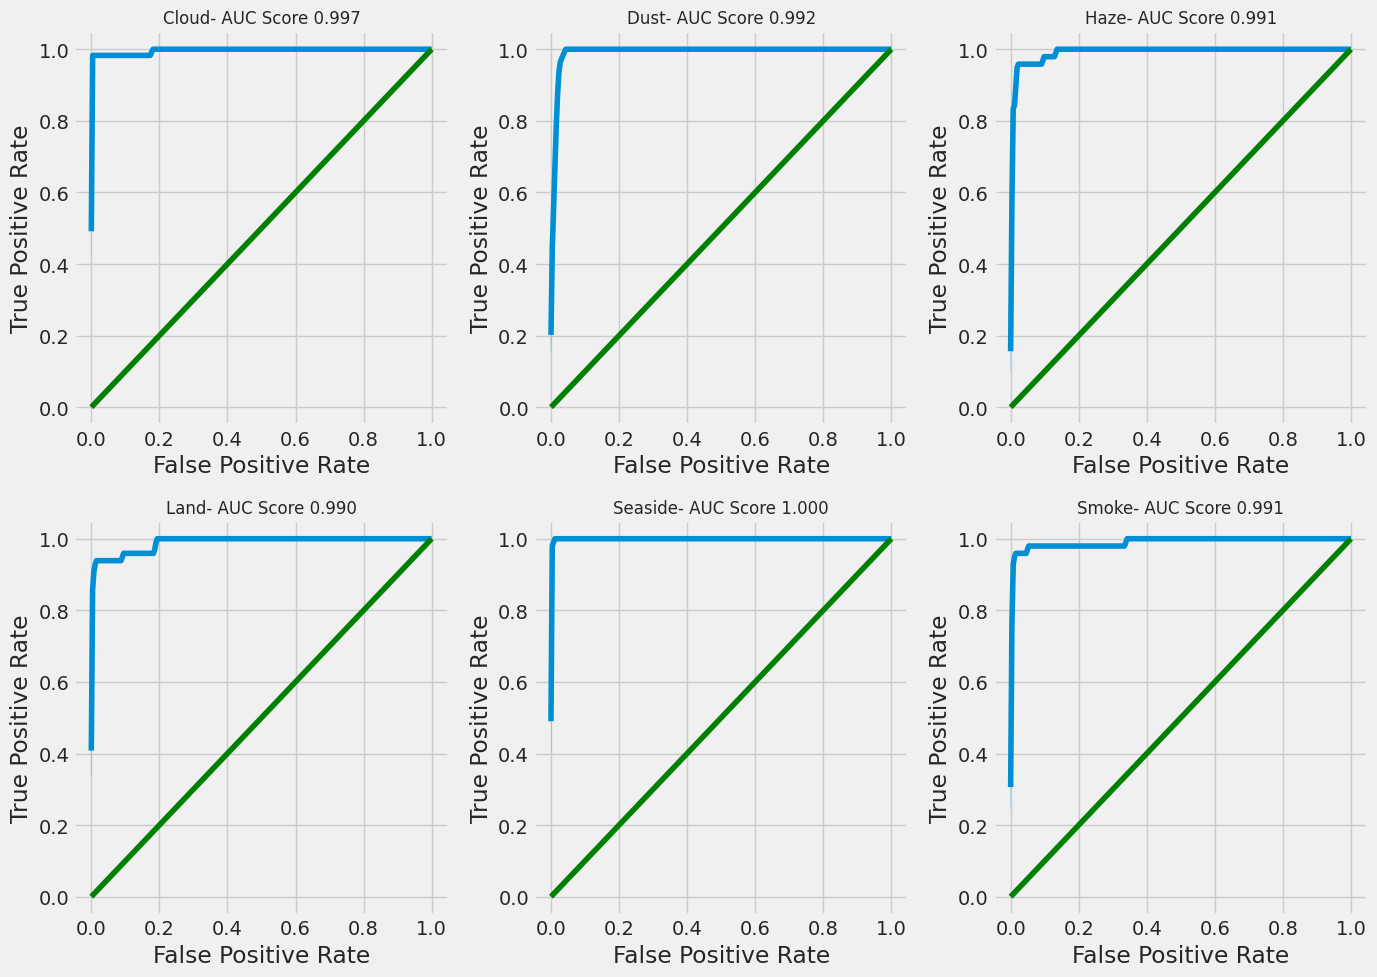

In [ ]:
def get_roc_values(real_values, probability):
    true_pos_rate_list = [0]
    false_pos_rate_list = [0]
    for i in range(len(probability)):
        limit = probability[i]
        predictions = probability >= limit
        true_pos_rate, false_pos_rate = cal_tpr_fpr(real_values, predictions)
        true_pos_rate_list.append(true_pos_rate)
        false_pos_rate_list.append(false_pos_rate)
    return true_pos_rate_list, false_pos_rate_list

#AUC-ROC Curve
def roc_curve_function( true_pos_rate, false_pos_rate,axis, scatter = True):
    if scatter:
        sns.scatterplot(x = false_pos_rate, y = true_pos_rate, axis = axis)
    sns.lineplot(x = false_pos_rate, y = true_pos_rate, ax = axis)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = axis)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


def cal_tpr_fpr(original_val, predicted_val):
    new_matrix = confusion_matrix(original_val, predicted_val)
    TruePos = new_matrix[1, 1]
    TrueNeg = new_matrix[0, 0]
    FalsePos = new_matrix[0, 1]
    FalseNeg = new_matrix[1, 0]
    true_pos_rate =  TruePos/(TruePos + FalseNeg)
    false_pos_rate = 1 - TrueNeg/(TrueNeg+FalsePos)
    return true_pos_rate, false_pos_rate


plt.figure(figsize = (14, 10))
list_labels=['Cloud','Dust','Haze','Land','Seaside','Smoke']
new_df = pd.DataFrame()
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i in range(0,6):
    original = i
    new_df['class'] = [1 if predicted == original else 0 for predicted in test_gen.classes]
    new_df['probability'] = preds[:, i]
    new_df = new_df.reset_index(drop = True)
    bottom_axis = plt.subplot(2, 3, i+1)
    true_pos_rate, false_pos_rate = get_roc_values(new_df['class'], new_df['probability'])
    roc_curve_function(  true_pos_rate, false_pos_rate, axis = bottom_axis, scatter = False)
    auc_values = roc_auc_score(new_df['class'], new_df['probability'])
    bottom_axis.set_title(list_labels[i]+'- AUC Score '+str(format(auc_values,".3f")),fontsize=12)
plt.tight_layout()

In [ ]:
model_name='Mobilenet'
base_model=tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

12683000/12683000 [==============================] - 2s 0us/step


In [ ]:
epochs =25
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
with tf.device("/gpu:0"):
    callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]
    history=model.fit(x=train_gen, epochs=epochs, verbose=1,callbacks=callbacks, validation_data=valid_gen,validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

Epoch 1/25
1804/1804 [==============================] - ETA: 0s - loss: 4.0526 - accuracy: 0.5244 1 /25     4.053   52.439  1430.91504 19.614   0.00100  0.00100  accuracy   97.15  

1804/1804 [==============================] - 97s 40ms/step - loss: 4.0526 - accuracy: 0.5244 - val_loss: 1430.9150 - val_accuracy: 0.1961
Epoch 2/25
1804/1804 [==============================] - ETA: 0s - loss: 1.5878 - accuracy: 0.6234 2 /25     1.588   62.343   6.24650  41.158   0.00100  0.00100  accuracy   68.52  

1804/1804 [==============================] - 69s 38ms/step - loss: 1.5878 - accuracy: 0.6234 - val_loss: 6.2465 - val_accuracy: 0.4116
Epoch 3/25
 3 /25     1.551   61.807  73.81147  28.296   0.00100  0.00050  accuracy   68.77  

1804/1804 [==============================] - 69s 38ms/step - loss: 1.5508 - accuracy: 0.6181 - val_loss: 73.8115 - val_ac

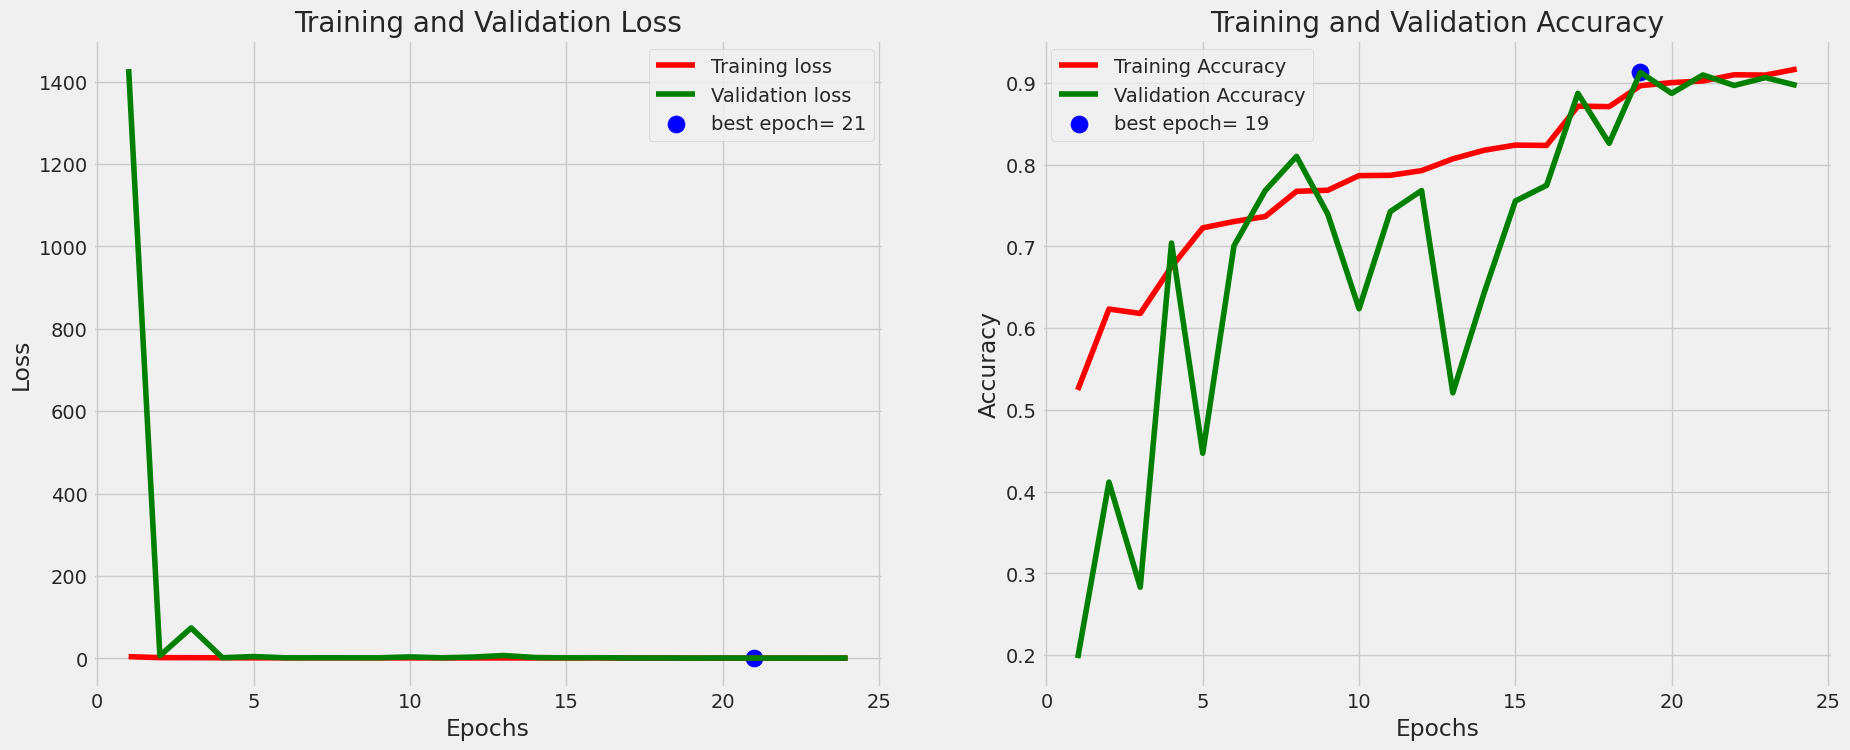

4/4 [==============================] - 1s 218ms/step - loss: 0.4998 - accuracy: 0.9359
accuracy on the test set is 93.59 %

model was saved as Mobilenet-scenes-93.58.h5



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='scenes'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
print_in_color ('model was saved as ' + save_id, (0,255,0),(55,65,80))
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

4/4 [==============================] - 2s 228ms/step


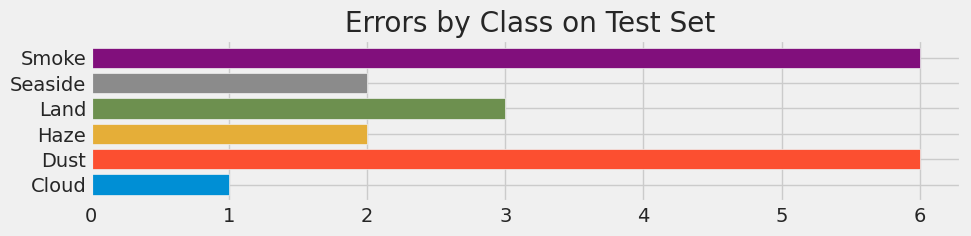

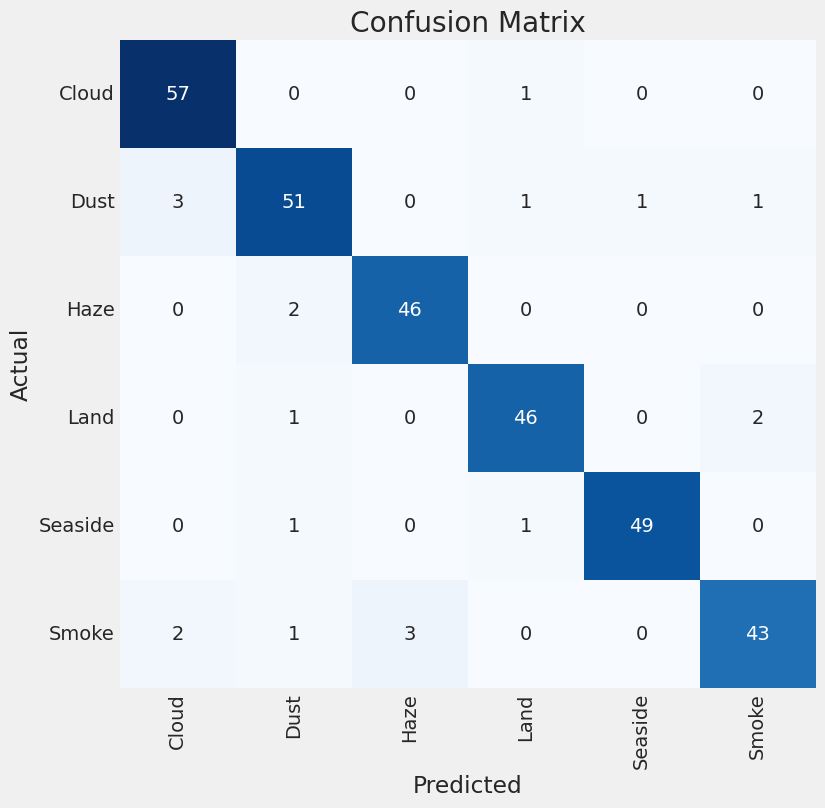

Classification Report:
----------------------
               precision    recall  f1-score   support

       Cloud       0.92      0.98      0.95        58
        Dust       0.91      0.89      0.90        57
        Haze       0.94      0.96      0.95        48
        Land       0.94      0.94      0.94        49
     Seaside       0.98      0.96      0.97        51
       Smoke       0.93      0.88      0.91        49

    accuracy                           0.94       312
   macro avg       0.94      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

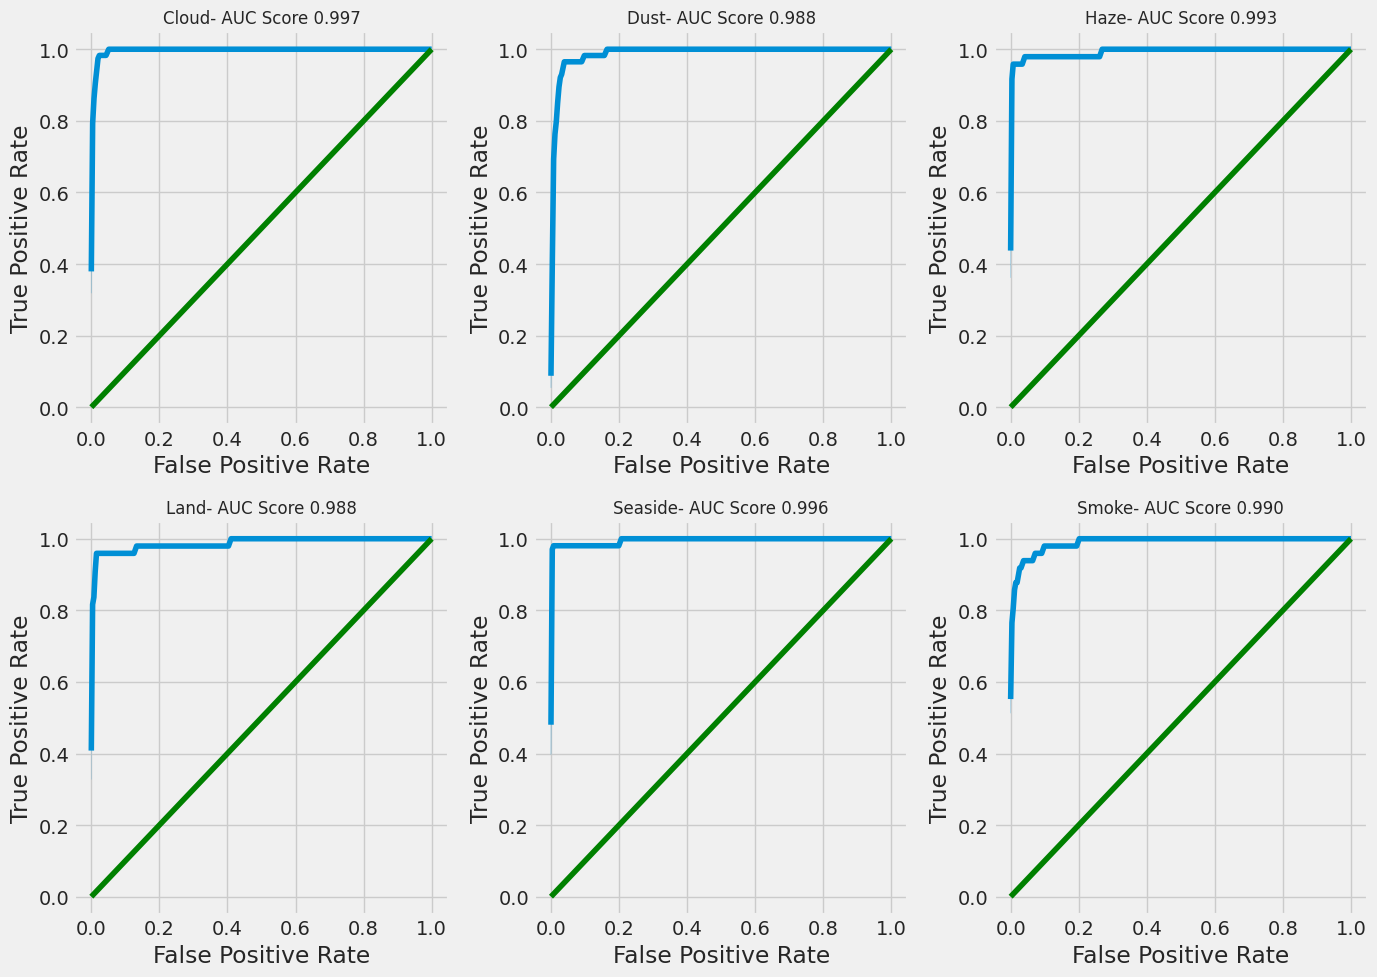

In [ ]:
def get_roc_values(real_values, probability):
    true_pos_rate_list = [0]
    false_pos_rate_list = [0]
    for i in range(len(probability)):
        limit = probability[i]
        predictions = probability >= limit
        true_pos_rate, false_pos_rate = cal_tpr_fpr(real_values, predictions)
        true_pos_rate_list.append(true_pos_rate)
        false_pos_rate_list.append(false_pos_rate)
    return true_pos_rate_list, false_pos_rate_list

#AUC-ROC Curve
def roc_curve_function( true_pos_rate, false_pos_rate,axis, scatter = True):
    if scatter:
        sns.scatterplot(x = false_pos_rate, y = true_pos_rate, axis = axis)
    sns.lineplot(x = false_pos_rate, y = true_pos_rate, ax = axis)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = axis)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


def cal_tpr_fpr(original_val, predicted_val):
    new_matrix = confusion_matrix(original_val, predicted_val)
    TruePos = new_matrix[1, 1]
    TrueNeg = new_matrix[0, 0]
    FalsePos = new_matrix[0, 1]
    FalseNeg = new_matrix[1, 0]
    true_pos_rate =  TruePos/(TruePos + FalseNeg)
    false_pos_rate = 1 - TrueNeg/(TrueNeg+FalsePos)
    return true_pos_rate, false_pos_rate


plt.figure(figsize = (14, 10))
list_labels=['Cloud','Dust','Haze','Land','Seaside','Smoke']
new_df = pd.DataFrame()
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i in range(0,6):
    original = i
    new_df['class'] = [1 if predicted == original else 0 for predicted in test_gen.classes]
    new_df['probability'] = preds[:, i]
    new_df = new_df.reset_index(drop = True)
    bottom_axis = plt.subplot(2, 3, i+1)
    true_pos_rate, false_pos_rate = get_roc_values(new_df['class'], new_df['probability'])
    roc_curve_function(  true_pos_rate, false_pos_rate, axis = bottom_axis, scatter = False)
    auc_values = roc_auc_score(new_df['class'], new_df['probability'])
    bottom_axis.set_title(list_labels[i]+'- AUC Score '+str(format(auc_values,".3f")),fontsize=12)
plt.tight_layout()

In [ ]:
model_name='Incpetion'
base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs =25
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
with tf.device("/gpu:0"):
    callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]
    history=model.fit(x=train_gen, epochs=epochs, verbose=1,callbacks=callbacks, validation_data=valid_gen,validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

Epoch 1/25
1804/1804 [==============================] - ETA: 0s - loss: 4.8805 - accuracy: 0.2336 1 /25     4.880   23.356  34.59099  26.367   0.00100  0.00100  accuracy   125.20 

1804/1804 [==============================] - 125s 55ms/step - loss: 4.8805 - accuracy: 0.2336 - val_loss: 34.5910 - val_accuracy: 0.2637
Epoch 2/25
1804/1804 [==============================] - ETA: 0s - loss: 1.9013 - accuracy: 0.2448 2 /25     1.901   24.483   1.79904  36.334   0.00100  0.00100  accuracy   97.67  

1804/1804 [==============================] - 98s 54ms/step - loss: 1.9013 - accuracy: 0.2448 - val_loss: 1.7990 - val_accuracy: 0.3633
Epoch 3/25
1804/1804 [==============================] - ETA: 0s - loss: 1.9045 - accuracy: 0.2363 3 /25     1.904   23.633  10.78722  35.691   0.00100  0.00050  accuracy   97.61  

1804/1804 [==========================

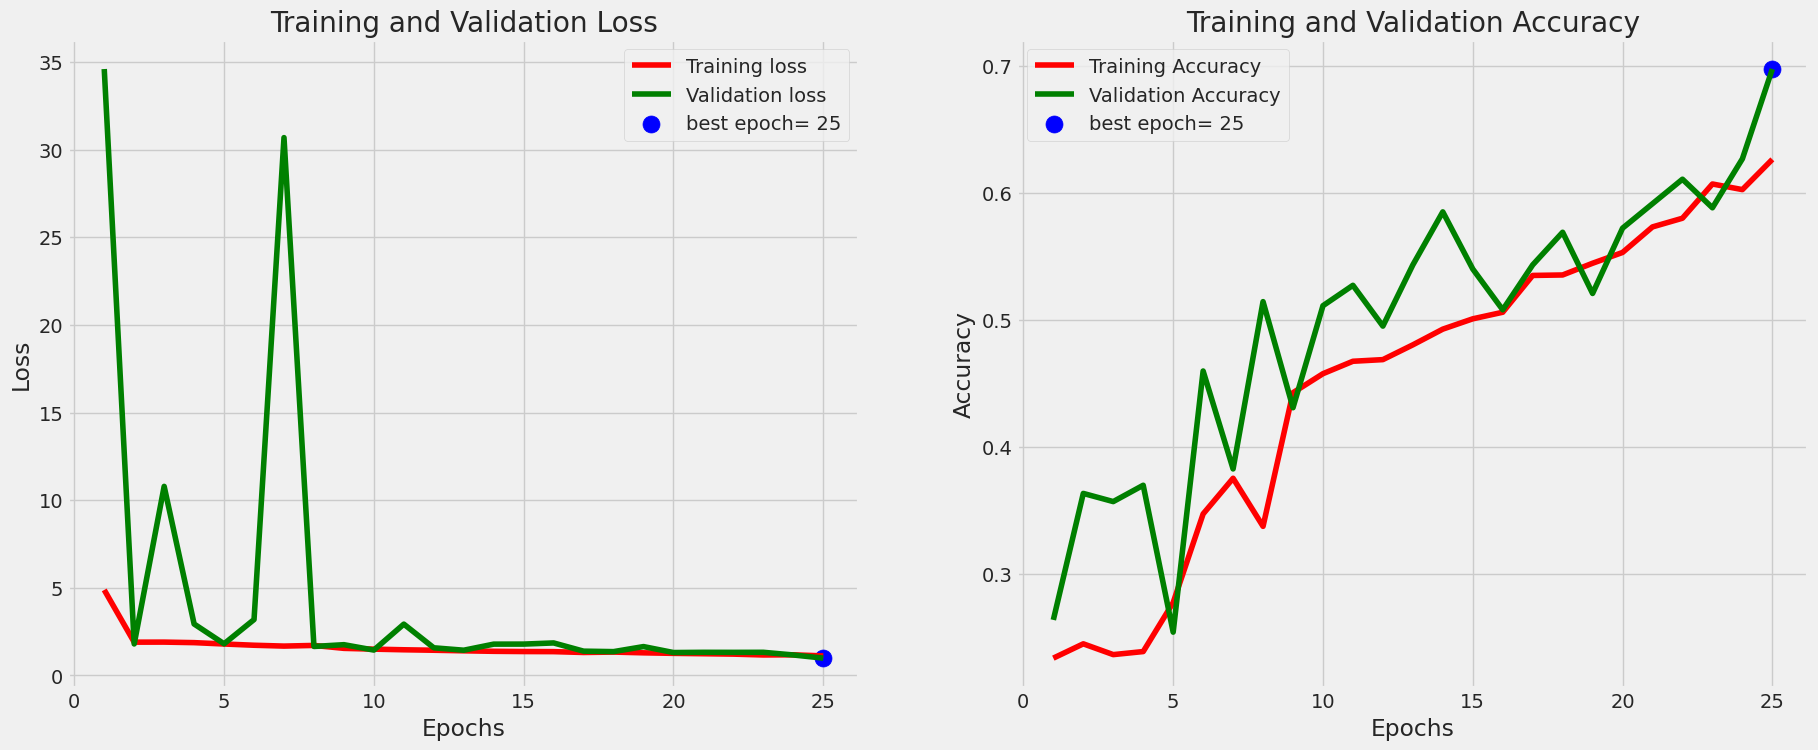

4/4 [==============================] - 1s 200ms/step - loss: 1.0010 - accuracy: 0.6859
accuracy on the test set is 68.59 %

model was saved as Incpetion-scenes-68.58.h5



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='scenes'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
print_in_color ('model was saved as ' + save_id, (0,255,0),(55,65,80))
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

4/4 [==============================] - 2s 221ms/step


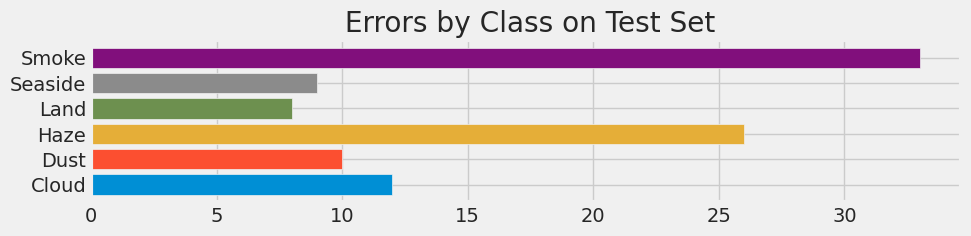

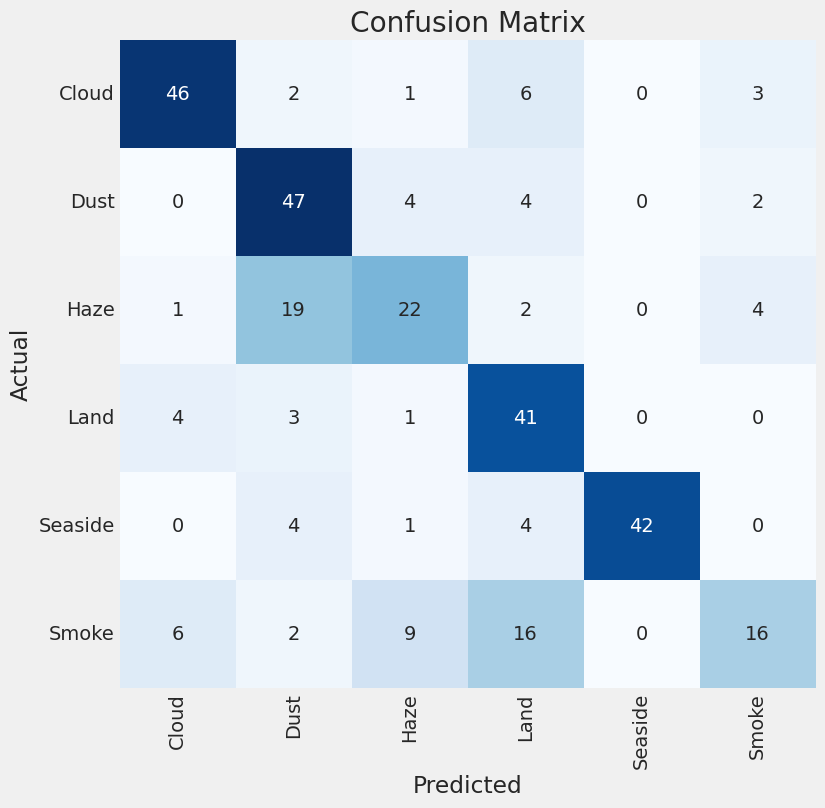

Classification Report:
----------------------
               precision    recall  f1-score   support

       Cloud       0.81      0.79      0.80        58
        Dust       0.61      0.82      0.70        57
        Haze       0.58      0.46      0.51        48
        Land       0.56      0.84      0.67        49
     Seaside       1.00      0.82      0.90        51
       Smoke       0.64      0.33      0.43        49

    accuracy                           0.69       312
   macro avg       0.70      0.68      0.67       312
weighted avg       0.70      0.69      0.68       312



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

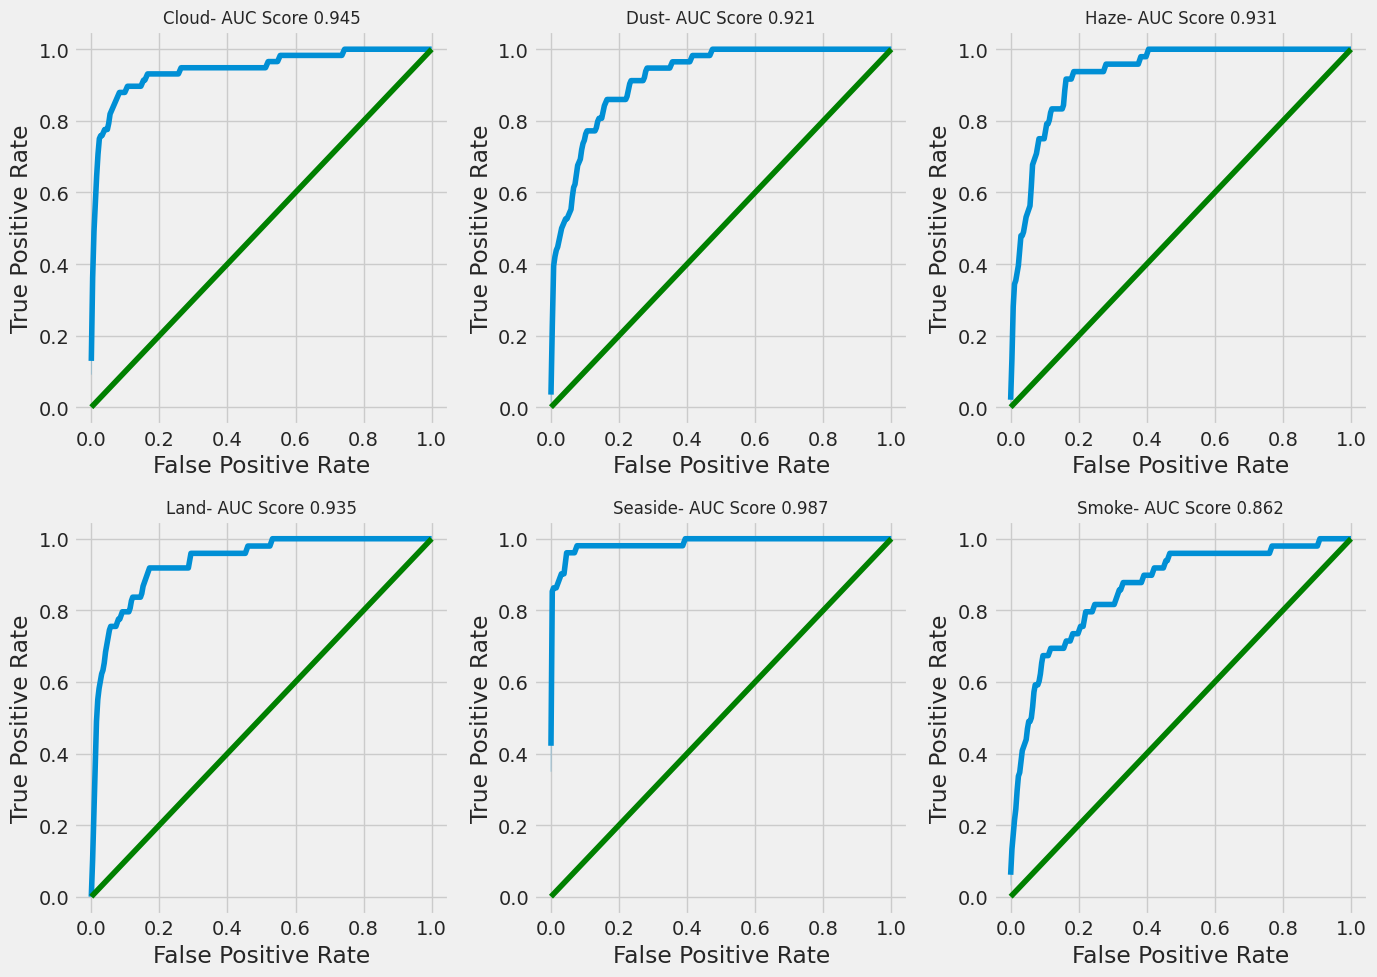

In [ ]:
def get_roc_values(real_values, probability):
    true_pos_rate_list = [0]
    false_pos_rate_list = [0]
    for i in range(len(probability)):
        limit = probability[i]
        predictions = probability >= limit
        true_pos_rate, false_pos_rate = cal_tpr_fpr(real_values, predictions)
        true_pos_rate_list.append(true_pos_rate)
        false_pos_rate_list.append(false_pos_rate)
    return true_pos_rate_list, false_pos_rate_list

#AUC-ROC Curve
def roc_curve_function( true_pos_rate, false_pos_rate,axis, scatter = True):
    if scatter:
        sns.scatterplot(x = false_pos_rate, y = true_pos_rate, axis = axis)
    sns.lineplot(x = false_pos_rate, y = true_pos_rate, ax = axis)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = axis)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


def cal_tpr_fpr(original_val, predicted_val):
    new_matrix = confusion_matrix(original_val, predicted_val)
    TruePos = new_matrix[1, 1]
    TrueNeg = new_matrix[0, 0]
    FalsePos = new_matrix[0, 1]
    FalseNeg = new_matrix[1, 0]
    true_pos_rate =  TruePos/(TruePos + FalseNeg)
    false_pos_rate = 1 - TrueNeg/(TrueNeg+FalsePos)
    return true_pos_rate, false_pos_rate


plt.figure(figsize = (14, 10))
list_labels=['Cloud','Dust','Haze','Land','Seaside','Smoke']
new_df = pd.DataFrame()
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i in range(0,6):
    original = i
    new_df['class'] = [1 if predicted == original else 0 for predicted in test_gen.classes]
    new_df['probability'] = preds[:, i]
    new_df = new_df.reset_index(drop = True)
    bottom_axis = plt.subplot(2, 3, i+1)
    true_pos_rate, false_pos_rate = get_roc_values(new_df['class'], new_df['probability'])
    roc_curve_function(  true_pos_rate, false_pos_rate, axis = bottom_axis, scatter = False)
    auc_values = roc_auc_score(new_df['class'], new_df['probability'])
    bottom_axis.set_title(list_labels[i]+'- AUC Score '+str(format(auc_values,".3f")),fontsize=12)
plt.tight_layout()